In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
#from custom_classes_defs.Unet_like import * 
from custom_classes_defs.unet import *   
# from custom_classes_defs.fnet import * 
# from custom_classes_defs.fnet1 import *
# from custom_classes_defs.hed import *

import keras
import numpy as np

from keras.utils import plot_model

RND_STATE = 247

BATCH_SIZE = 64
# size 512 to have around 351 iterations
# size 256 to have around 707 iterations

keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

NEW_SESSION = False

# import keras_tuner as kt
# -------------------------------------------------------

2024-05-07 13:23:28.292289: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 13:23:29.426140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 13:23:29.426634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 13:23:29.555800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 13:23:29.875946: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

#if NUM_GPU:
#    # print GPU info
#    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


In [6]:
# Input data path
seis_path = './data_thebe/seis/'
label_path = './data_thebe/fault/'


In [7]:
time_start= time.time()
thebe_data = Thebe(seis_path,label_path, batch_size=BATCH_SIZE)

train_dataset = thebe_data.data_generator(sub_group='train',cache=True)
val_dataset = thebe_data.data_generator(sub_group='val',cache= True)
test_dataset = thebe_data.data_generator(sub_group='test',cache= True)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

2024-05-07 13:24:49.233822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 33787 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:af:00.0, compute capability: 8.0


Loading time used 1.1082911292711894 mins


In [8]:
print(f"training data (size = {(train_dataset.cardinality().numpy())*BATCH_SIZE})")
print(f"validation data (size = {(val_dataset.cardinality().numpy())*BATCH_SIZE})")
print(f"test data (size = {(test_dataset.cardinality().numpy())*BATCH_SIZE})")
print("Data images tensor:",train_dataset.element_spec[0])
print("Data labels tensor:",train_dataset.element_spec[1])

training data (size = 181056)
validation data (size = 64320)
test data (size = 66112)
Data images tensor: TensorSpec(shape=(None, 96, 96), dtype=tf.float32, name=None)
Data labels tensor: TensorSpec(shape=(None, 96, 96), dtype=tf.float32, name=None)


In [9]:


# Model configurations
conf = model_config(
    epochs= 30,
    batch_size=BATCH_SIZE,
    verbose=0,
    scaling=1,
    save_path='./output/unet',
    img_shape= (96,96),
    target_size= (96,96),
    channels_dim=(1,1),
    pos_label= thebe_data.pos_label,
    new_training_session=True,
    mixed_precision = False,
    multiple_gpu_device=None
)


callbacks=conf.callbacks(chkpt_monitor='val_loss', es_patience=30, lr_patience= 5)
conf.set( validation_data=val_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    metrics= ['accuracy']
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: <class 'keras.src.optimizers.adam.Adam'>
                          loss: binary_crossentropy
                       metrics: accuracy
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: False
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: None
new_training_session: True
           pos_label: 1
           save_path: ./output/unet
             scaling: 1
         target_size: (96, 96)
           test_size: None
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 30
                    batch_size: 64
                       shuffle: False
                       verbose: 0
  

### Build model

In [10]:
### SINGLE-HOST, MULTI-DEVICE SYNCHRONOUS TRAINING
## François Chollet. Deep Learning with Python, Second Edition (Kindle Location 12675). Manning Publications Co.. 
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)

#model.summary()
#plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 3,083,969
Total trainable wieghts: 3,080,193
Total non-trainable wieghts: 3,776


### Train the model



	Train unet model
-------------------------------------------------------
Model training...


2024-05-07 13:26:05.189779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-NET/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-07 13:26:06.889732: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-07 13:26:23.449109: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f32c0b86a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-07 13:26:23.449147: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-05-07 13:26:23.584895: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1715081184.491770 2817385 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.



Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.



Epoch 16: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.



Epoch 21: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.



Epoch 26: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.


training elapsed time: ___52.05___ minutes
...training completed!


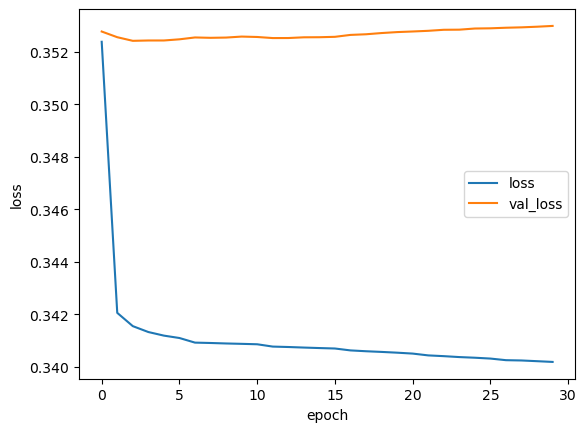

Loading time used 52.09256672461827 mins


In [11]:
time_start= time.time()

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

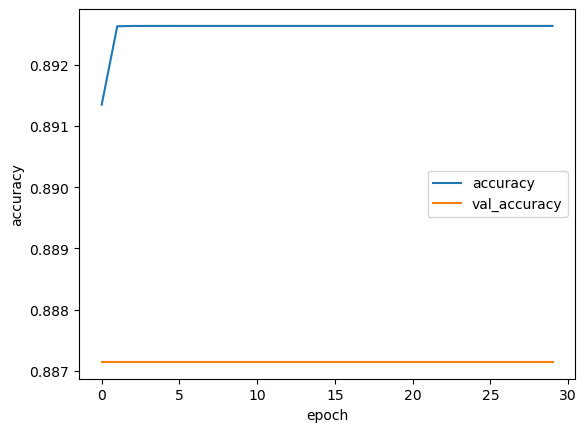

In [12]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

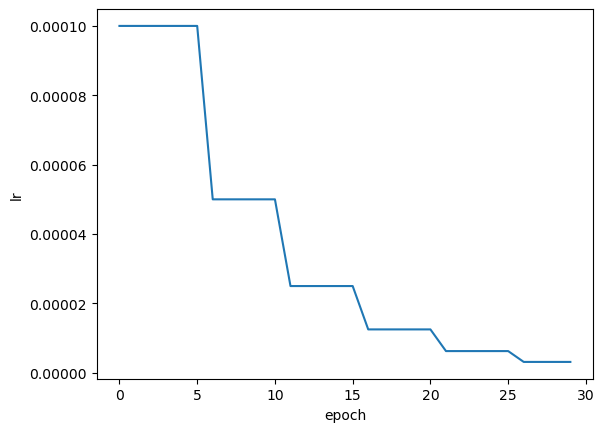

In [13]:
show_convergence(train_history.history, 'lr')

### Visualize predictions

In [14]:
#time_start= time.time()
#y_preds = model.predict(test_dataset)

#time_end = (time.time()-time_start)/60
#print(f'Loading time used {time_end} mins')

In [15]:
#time_start= time.time()

#print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))

#model.evaluate(x=test_dataset)
#time_end = (time.time()-time_start)/60
#print(f'Loading time used {time_end} mins')

In [16]:
# Using scikit-learn
#scores = m_obj.evaluate_sklearn(test_dataset, y_preds,report=True)
#print(scores)


In [17]:
#if NEW_SESSION:
#    thebe_data.display_sample_image(y_preds, 'test')